# History Summary

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

### Get all History File Paths

In [19]:
a = ['a','b','c']
a.index('b')

1

In [47]:
output_dir = './summary/v1.4/'
history_dir = './history/'
versions_in_scope = ['v1.4']

os.makedirs(output_dir,exist_ok=True)
os.makedirs(history_dir,exist_ok=True)

versions, datasets, fx_models, clf_models, runs, paths = [], [], [], [], [], []

for version in os.listdir(history_dir):
    if version not in versions_in_scope:
        continue
    version_dir = os.path.join(history_dir,version)
    for dataset in os.listdir(version_dir):
        dataset_dir = os.path.join(version_dir,dataset)
        for model in os.listdir(dataset_dir):
            model_split = model.split('_')
            fx_model = '_'.join(model_split[1:model_split.index('CLF')])
            clf_model = '_'.join(model_split[model_split.index('CLF')+1:])
            model_dir = os.path.join(dataset_dir,model)
            for run in os.listdir(model_dir):
                path = os.path.join(model_dir,run,'history.pt')
                if not os.path.isfile(path): continue
                versions.append(version)
                datasets.append(dataset)
                fx_models.append(fx_model)
                clf_models.append(clf_model)
                runs.append(run)
                paths.append(path)

history_files = pd.DataFrame.from_dict(dict(version=versions,dataset=datasets,fx_model=fx_models,clf_model=clf_models,run=runs,path=paths))
history_files.describe()

,version,dataset,fx_model,clf_model,run,path
count,415,415,415,415,415,415
unique,1,7,6,2,5,415
top,v1.4,RAVDESS,HUBERT_BASE,PROBING_DENSE,Run1,./history/v1.4/RAVDESS/FX_WAV2VEC2_LARGE_XLSR3...
freq,415,60,70,210,84,1


### Get by Classifier

In [48]:
probing_dense_history_files = history_files[history_files.clf_model=='PROBING_DENSE']
probing_history_files = history_files[history_files.clf_model=='PROBING']

##### PROBING

In [49]:
mean_accs, std_accs, max_accs, models, datasets = [], [], [], [], []
for model in probing_history_files.fx_model.unique():
    for dataset in probing_history_files.dataset.unique():
        run_df = probing_history_files[(probing_history_files.dataset==dataset) & (probing_history_files.fx_model==model)]
        test_accs = []
        for run in range(run_df.shape[0]):
            history = torch.load(run_df.iloc[run].path)
            hs_idx = np.argmax(history['val_acc'],axis=0)
            ts_acc = np.array(history['test_acc']).transpose()
            test_accs.append([acc[idx] for acc, idx in zip (ts_acc,hs_idx)])

        mean_accs.append(np.mean(test_accs,axis=0))
        max_accs.append(np.max(test_accs))
        std_accs.append(np.std(test_accs,axis=0))
        models.append(model)
        datasets.append(dataset)

probing_summary = pd.DataFrame.from_dict(dict(dataset=datasets,model=models,mean_accuracy=mean_accs,std_accuracy=std_accs,max_accuracy=max_accs))
probing_summary.sort_values(['dataset','model']).reset_index(drop=True).drop(['max_accuracy'],axis=1).to_csv(os.path.join(output_dir,'probing_summary.csv'))

In [50]:
mean_accs, std_accs, max_accs, models, datasets = [], [], [], [], []
for model in probing_dense_history_files.fx_model.unique():
    for dataset in probing_dense_history_files.dataset.unique():
        run_df = probing_dense_history_files[(probing_dense_history_files.dataset==dataset) & (probing_dense_history_files.fx_model==model)]
        test_accs = []
        for run in range(run_df.shape[0]):
            history = torch.load(run_df.iloc[run].path)
            hs_idx = np.argmax(history['val_acc'],axis=0)
            ts_acc = np.array(history['test_acc']).transpose()
            test_accs.append([acc[idx] for acc, idx in zip (ts_acc,hs_idx)])

        mean_accs.append(np.mean(test_accs,axis=0))
        max_accs.append(np.max(test_accs))
        std_accs.append(np.std(test_accs,axis=0))
        models.append(model)
        datasets.append(dataset)

probing_dense_summary = pd.DataFrame.from_dict(dict(dataset=datasets,model=models,mean_accuracy=mean_accs,std_accuracy=std_accs,max_accuracy=max_accs))
probing_dense_summary.sort_values(['dataset','model']).reset_index(drop=True).drop(['max_accuracy'],axis=1).to_csv(os.path.join(output_dir,'probing_dense_summary.csv'))

##### DENSE

In [13]:
mean_accs, std_accs, max_accs, models, datasets = [], [], [], [], []
for model in dense_history_files.fx_model.unique():
    for dataset in dense_history_files.dataset.unique():
        run_df = dense_history_files[(dense_history_files.dataset==dataset) & (dense_history_files.fx_model==model)]
        test_accs = []
        for run in range(run_df.shape[0]):
            history = torch.load(run_df.iloc[run].path)
            test_accs.append(history['test_acc'][history['val_acc'].index(max(history['val_acc']))])
        mean_accs.append(np.mean(test_accs))
        std_accs.append(np.std(test_accs))
        max_accs.append(np.max(test_accs))
        models.append(model)
        datasets.append(dataset)

dense_summary = pd.DataFrame.from_dict(dict(dataset=datasets,model=models,max_acuracy=max_accs,mean_accuracy=mean_accs,std_accuracy=std_accs))

In [19]:
top_1, top_3, layers = [], [], []
for row in range(dense_summary.shape[0]):
    dense_row = dense_summary.iloc[row]
    probing_row = probing_summary[(probing_summary.model==dense_row.model)&(probing_summary.dataset==dense_row.dataset)]
    prob_acc = probing_row.mean_accuracy
    accs = sorted(prob_acc.iloc[0])[-3:]
    mean = np.mean(accs)
    std = np.std(accs)
    top_3.append(f'{round(mean,2)} ({round(std,2)})')
    top_1.append(probing_row.max_accuracy.iloc[0])
    layers.append(np.argsort(prob_acc.iloc[0])[-3:]+1)
    
dense_summary['probing_max_acc'] = top_1
dense_summary['probing_top_3'] = top_3
dense_summary['probing_top_layers'] = layers

dense_summary.sort_values(['dataset','model']).reset_index(drop=True).to_csv(os.path.join(output_dir,'dense_summary.csv'))

---

### Plots

#### Dataset wise

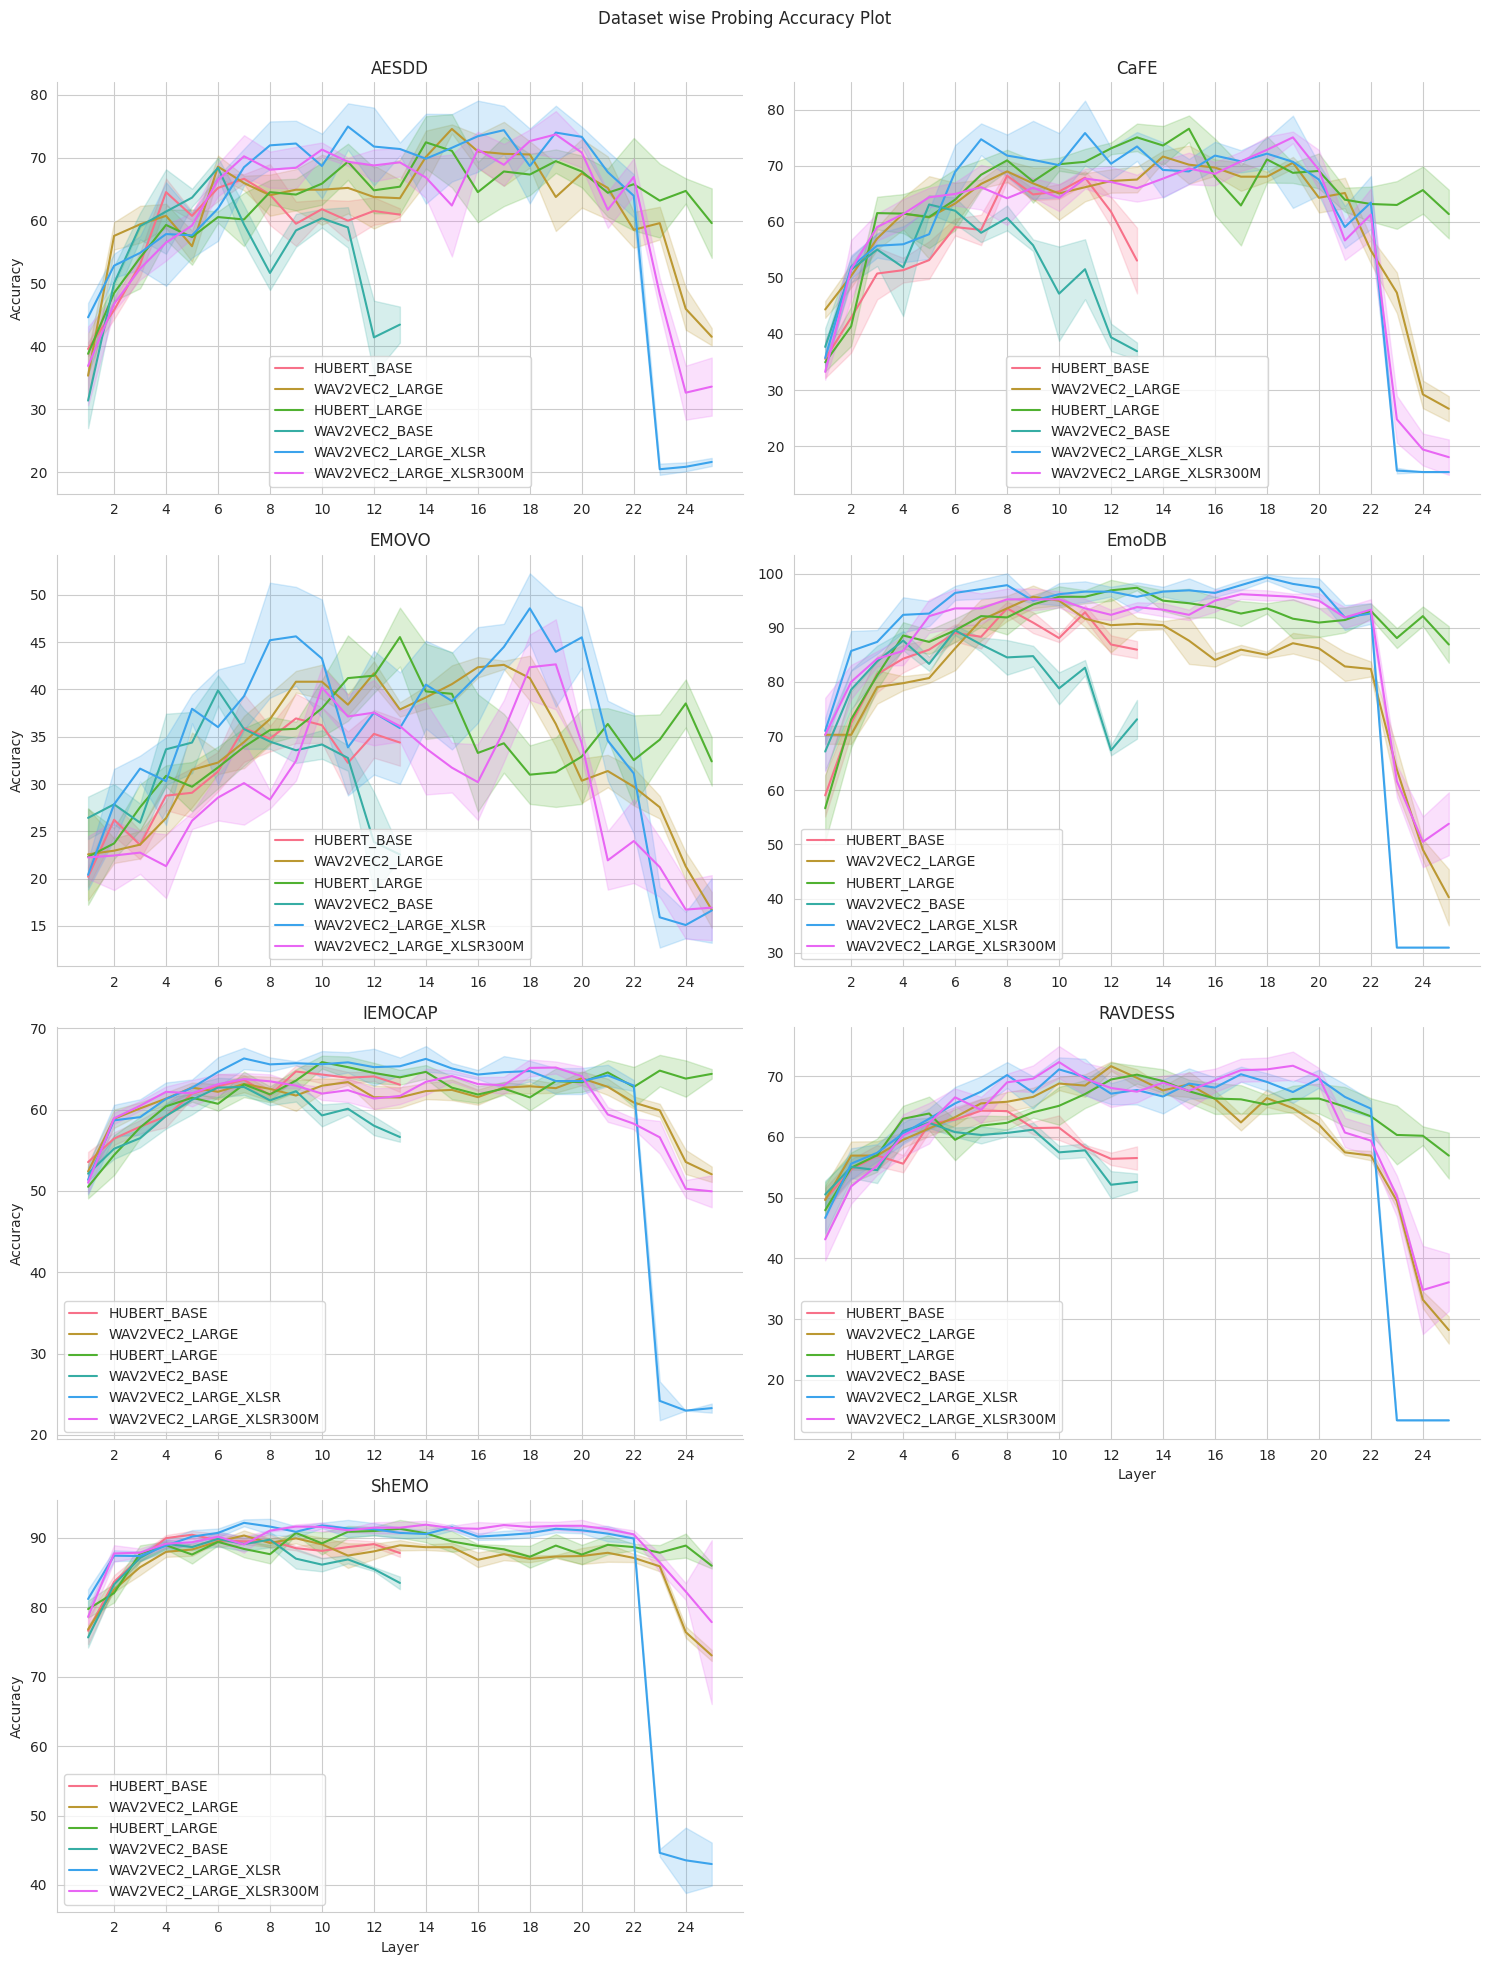

In [52]:
# Set figure
fig, ax = plt.subplots(4, 2,figsize=(15,20))
sns.set_style('whitegrid')

axes = np.array(ax).flatten()
datasets = sorted(probing_summary.dataset.unique())
for idx in range(len(datasets)):
    ax = axes[idx]
    dataset= datasets[idx]
    mean_accs, layers, models = [], [], []
    df = probing_summary[probing_summary.dataset==dataset]
    for row in range(df.shape[0]):
        mean_accs.extend(df.iloc[row].mean_accuracy)
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)+np.array(df.iloc[row].std_accuracy))
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)-np.array(df.iloc[row].std_accuracy))
        models.extend(([df.iloc[row].model]*len(df.iloc[row].mean_accuracy)*3))
        layers.extend([*range(1,len(df.iloc[row].mean_accuracy)+1)]*3)
    df = pd.DataFrame.from_dict(dict(model=models,layer=layers,mean_accuracy=mean_accs))

    # Plot the lines
    sns.lineplot(df ,x='layer',y='mean_accuracy', hue='model',dashes=False,palette=sns.color_palette("husl",len(df.model.unique())),errorbar=('ci',100),ax=ax)   
    # Adjust border
    sns.despine(top=True,right=True)

    # Set Labels, legends and ticks
    ax.set_title(dataset)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(facecolor="w")#,loc=4,title='IDR')
    ax.set_xticks([*range(2,25,2)],labels=[*range(2,25,2)])
    # ax.set_xlim(1,30.6)

# Plot
axes[-2].set_xlabel("Layer")
axes[-3].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[2].set_ylabel("Accuracy")
axes[4].set_ylabel("Accuracy")
axes[6].set_ylabel("Accuracy")
axes[-1].axis('off')
plt.suptitle('Dataset wise Probing Accuracy Plot\n\n')
plt.tight_layout()

plt.savefig(os.path.join(output_dir,'dataset_wise_probing_accuracy_plot.png'),bbox_inches="tight");
# plt.savefig(os.path.join(output_dir,'dataset_wise_probing_accuracy_plot.svg'),bbox_inches="tight");

# plt.clf();
# plt.close('all');

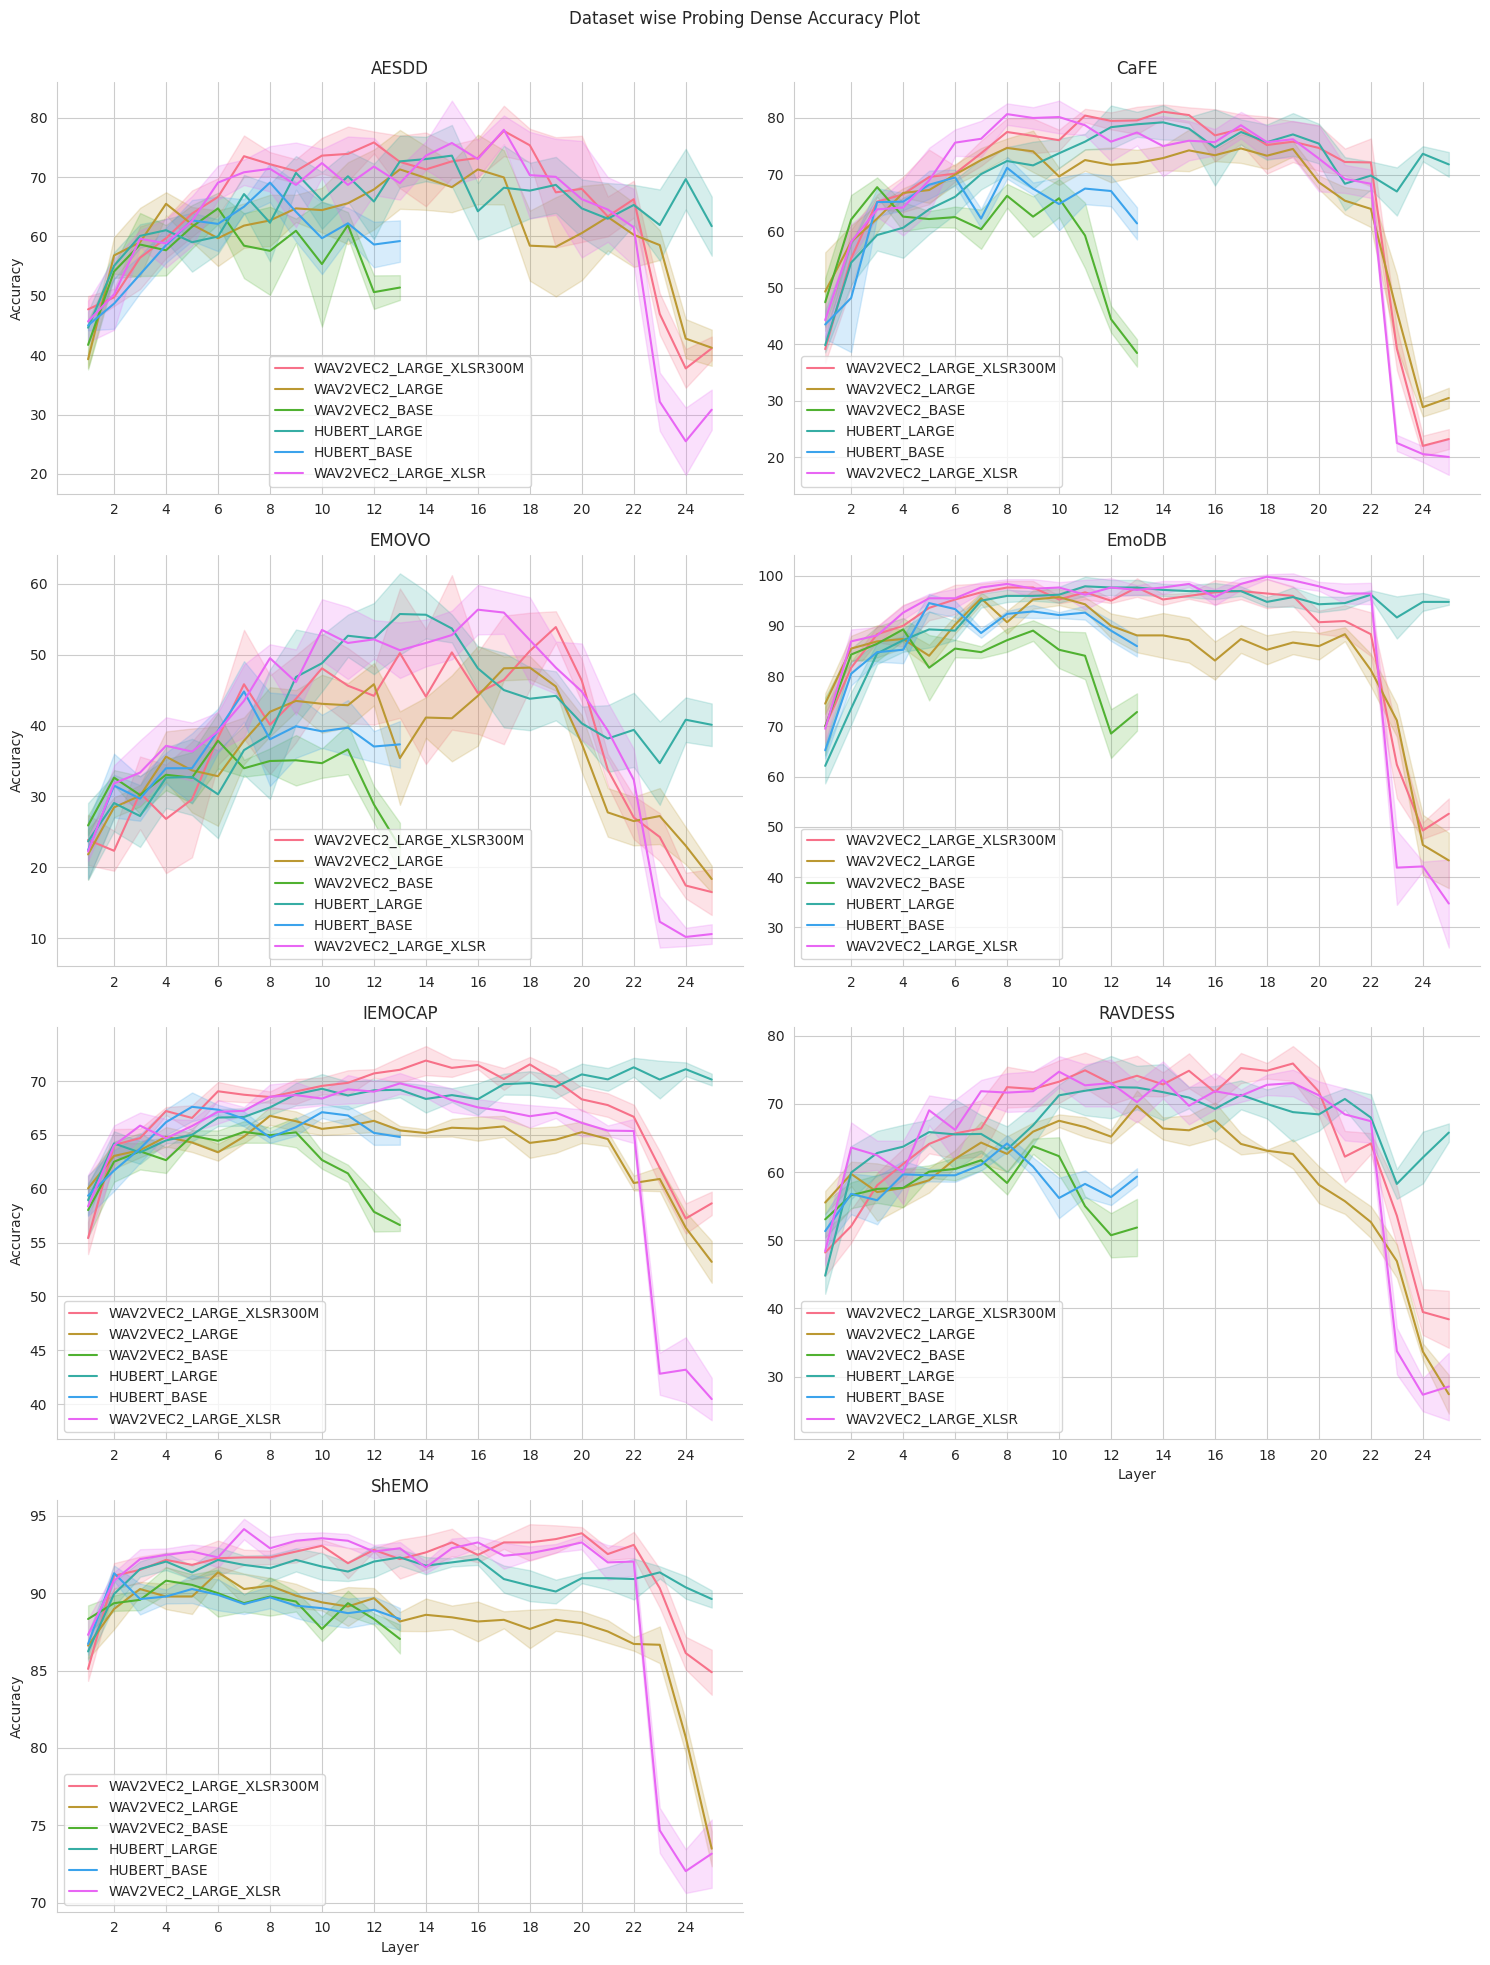

In [53]:
# Set figure
fig, ax = plt.subplots(4, 2,figsize=(15,20))
sns.set_style('whitegrid')

axes = np.array(ax).flatten()
datasets = sorted(probing_dense_summary.dataset.unique())
for idx in range(len(datasets)):
    ax = axes[idx]
    dataset= datasets[idx]
    mean_accs, layers, models = [], [], []
    df = probing_dense_summary[probing_dense_summary.dataset==dataset]
    for row in range(df.shape[0]):
        mean_accs.extend(df.iloc[row].mean_accuracy)
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)+np.array(df.iloc[row].std_accuracy))
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)-np.array(df.iloc[row].std_accuracy))
        models.extend(([df.iloc[row].model]*len(df.iloc[row].mean_accuracy)*3))
        layers.extend([*range(1,len(df.iloc[row].mean_accuracy)+1)]*3)
    df = pd.DataFrame.from_dict(dict(model=models,layer=layers,mean_accuracy=mean_accs))

    # Plot the lines
    sns.lineplot(df ,x='layer',y='mean_accuracy', hue='model',dashes=False,palette=sns.color_palette("husl",len(df.model.unique())),errorbar=('ci',100),ax=ax)   
    # Adjust border
    sns.despine(top=True,right=True)

    # Set Labels, legends and ticks
    ax.set_title(dataset)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(facecolor="w")#,loc=4,title='IDR')
    ax.set_xticks([*range(2,25,2)],labels=[*range(2,25,2)])
    # ax.set_xlim(1,30.6)

# Plot
axes[-2].set_xlabel("Layer")
axes[-3].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[2].set_ylabel("Accuracy")
axes[4].set_ylabel("Accuracy")
axes[6].set_ylabel("Accuracy")
axes[-1].axis('off')
plt.suptitle('Dataset wise Probing Dense Accuracy Plot\n\n')
plt.tight_layout()

plt.savefig(os.path.join(output_dir,'dataset_wise_probing_dense_accuracy_plot.png'),bbox_inches="tight");
# plt.savefig(os.path.join(output_dir,'dataset_wise_probing_accuracy_plot.svg'),bbox_inches="tight");

# plt.clf();
# plt.close('all');

#### Model wise

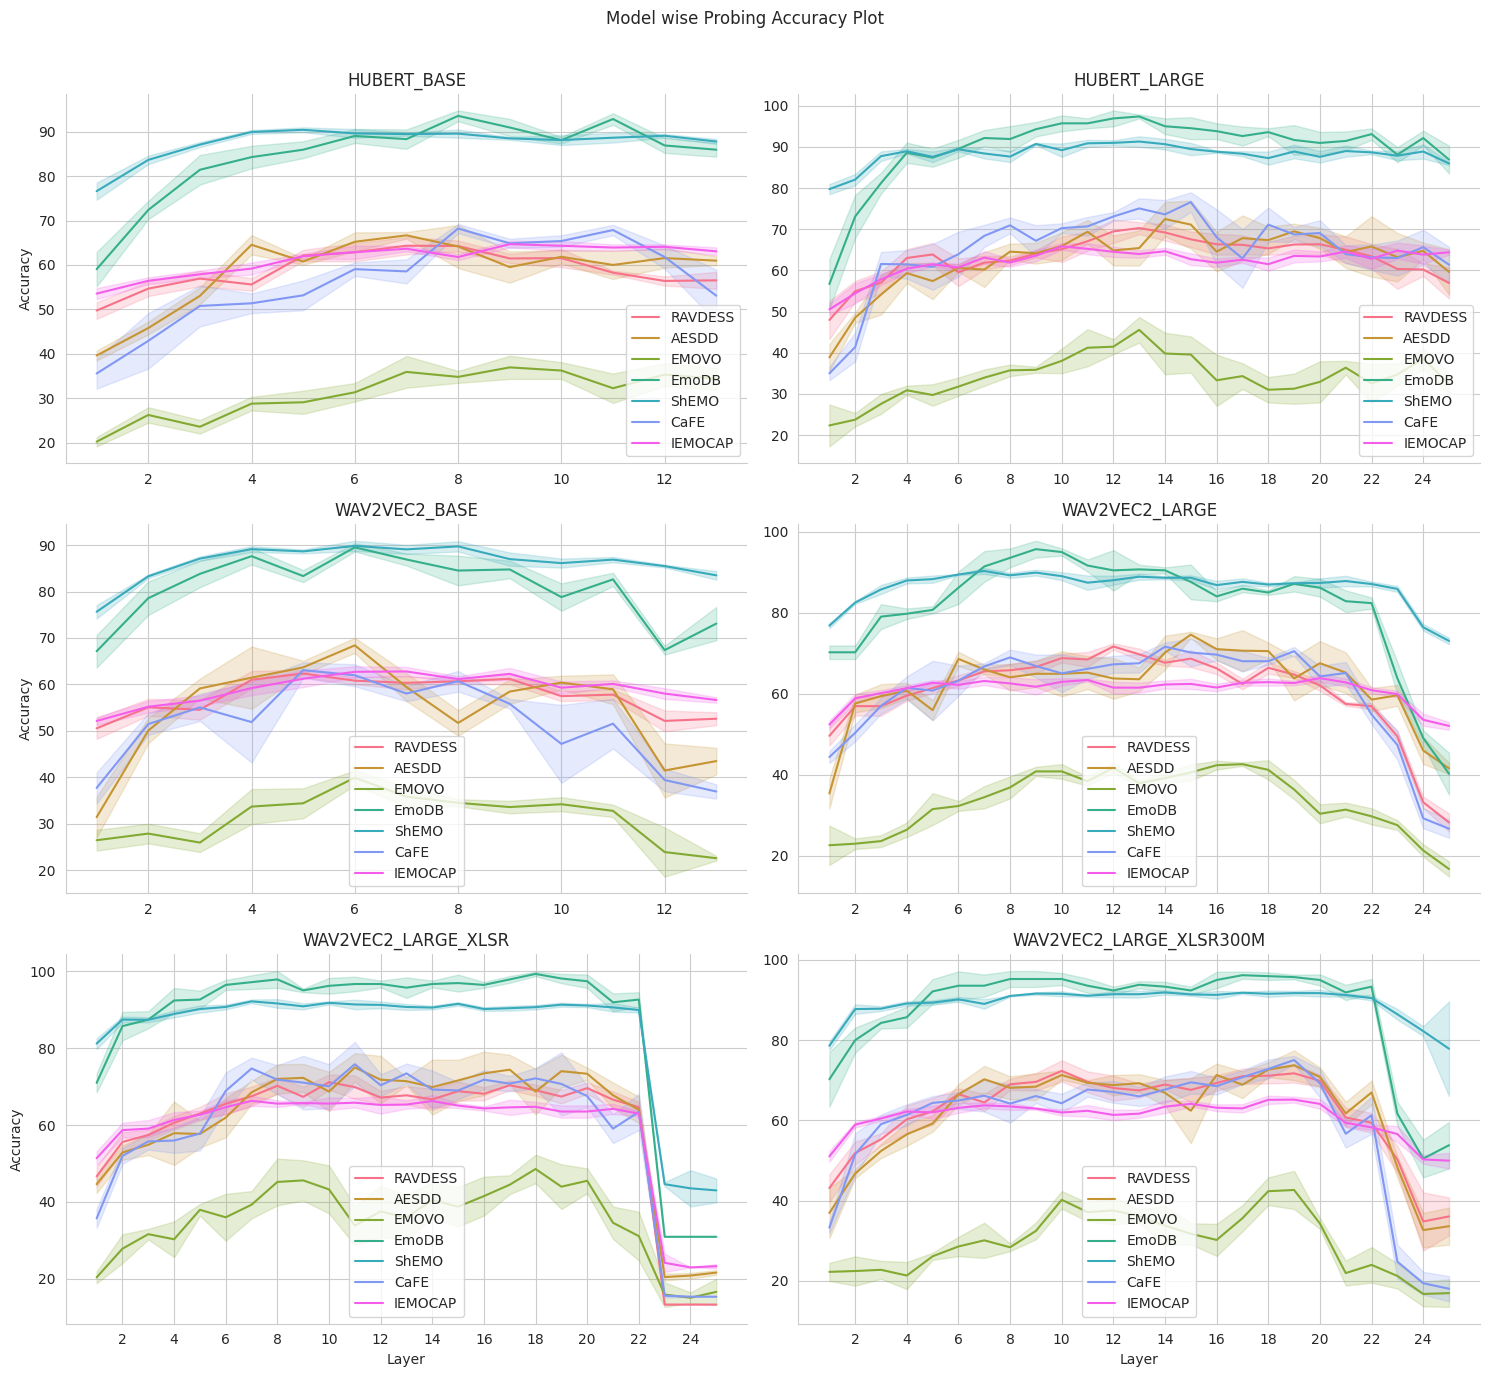

In [54]:
# Set figure
fig, ax = plt.subplots(3, 2,figsize=(15,14))
sns.set_style('whitegrid')

axes = np.array(ax).flatten()
models = sorted(probing_summary.model.unique())
for idx in range(len(models)):
    ax = axes[idx]
    model= models[idx]
    mean_accs, layers, datasets = [], [], []
    df = probing_summary[probing_summary.model==model]
    for row in range(df.shape[0]):
        mean_accs.extend(df.iloc[row].mean_accuracy)
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)+np.array(df.iloc[row].std_accuracy))
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)-np.array(df.iloc[row].std_accuracy))
        datasets.extend(([df.iloc[row].dataset]*len(df.iloc[row].mean_accuracy)*3))
        layers.extend([*range(1,len(df.iloc[row].mean_accuracy)+1)]*3)
    df = pd.DataFrame.from_dict(dict(dataset=datasets,layer=layers,mean_accuracy=mean_accs))

    # Plot the lines
    sns.lineplot(df ,x='layer',y='mean_accuracy', hue='dataset',dashes=False,palette=sns.color_palette("husl",len(df.dataset.unique())),errorbar=('ci',100),ax=ax)   
    # Adjust border
    sns.despine(top=True,right=True)

    # Set Labels, legends and ticks
    ax.set_title(model)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(facecolor="w")#,loc=4,title='IDR')
    ax.set_xticks([*range(2,len(df.layer.unique())+1,2)],labels=[*range(2,len(df.layer.unique())+1,2)])
    # ax.set_xlim(1,30.6)

# Plot
axes[-1].set_xlabel("Layer")
axes[-2].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[2].set_ylabel("Accuracy")
axes[4].set_ylabel("Accuracy")
plt.suptitle('Model wise Probing Accuracy Plot\n\n')
plt.tight_layout()

plt.savefig(os.path.join(output_dir,'model_wise_probing_accuracy_plot.png'),bbox_inches="tight");
# plt.savefig(os.path.join(output_dir,'model_wise_probing_accuracy_plot.svg'),bbox_inches="tight");


# plt.clf();
# plt.close('all');

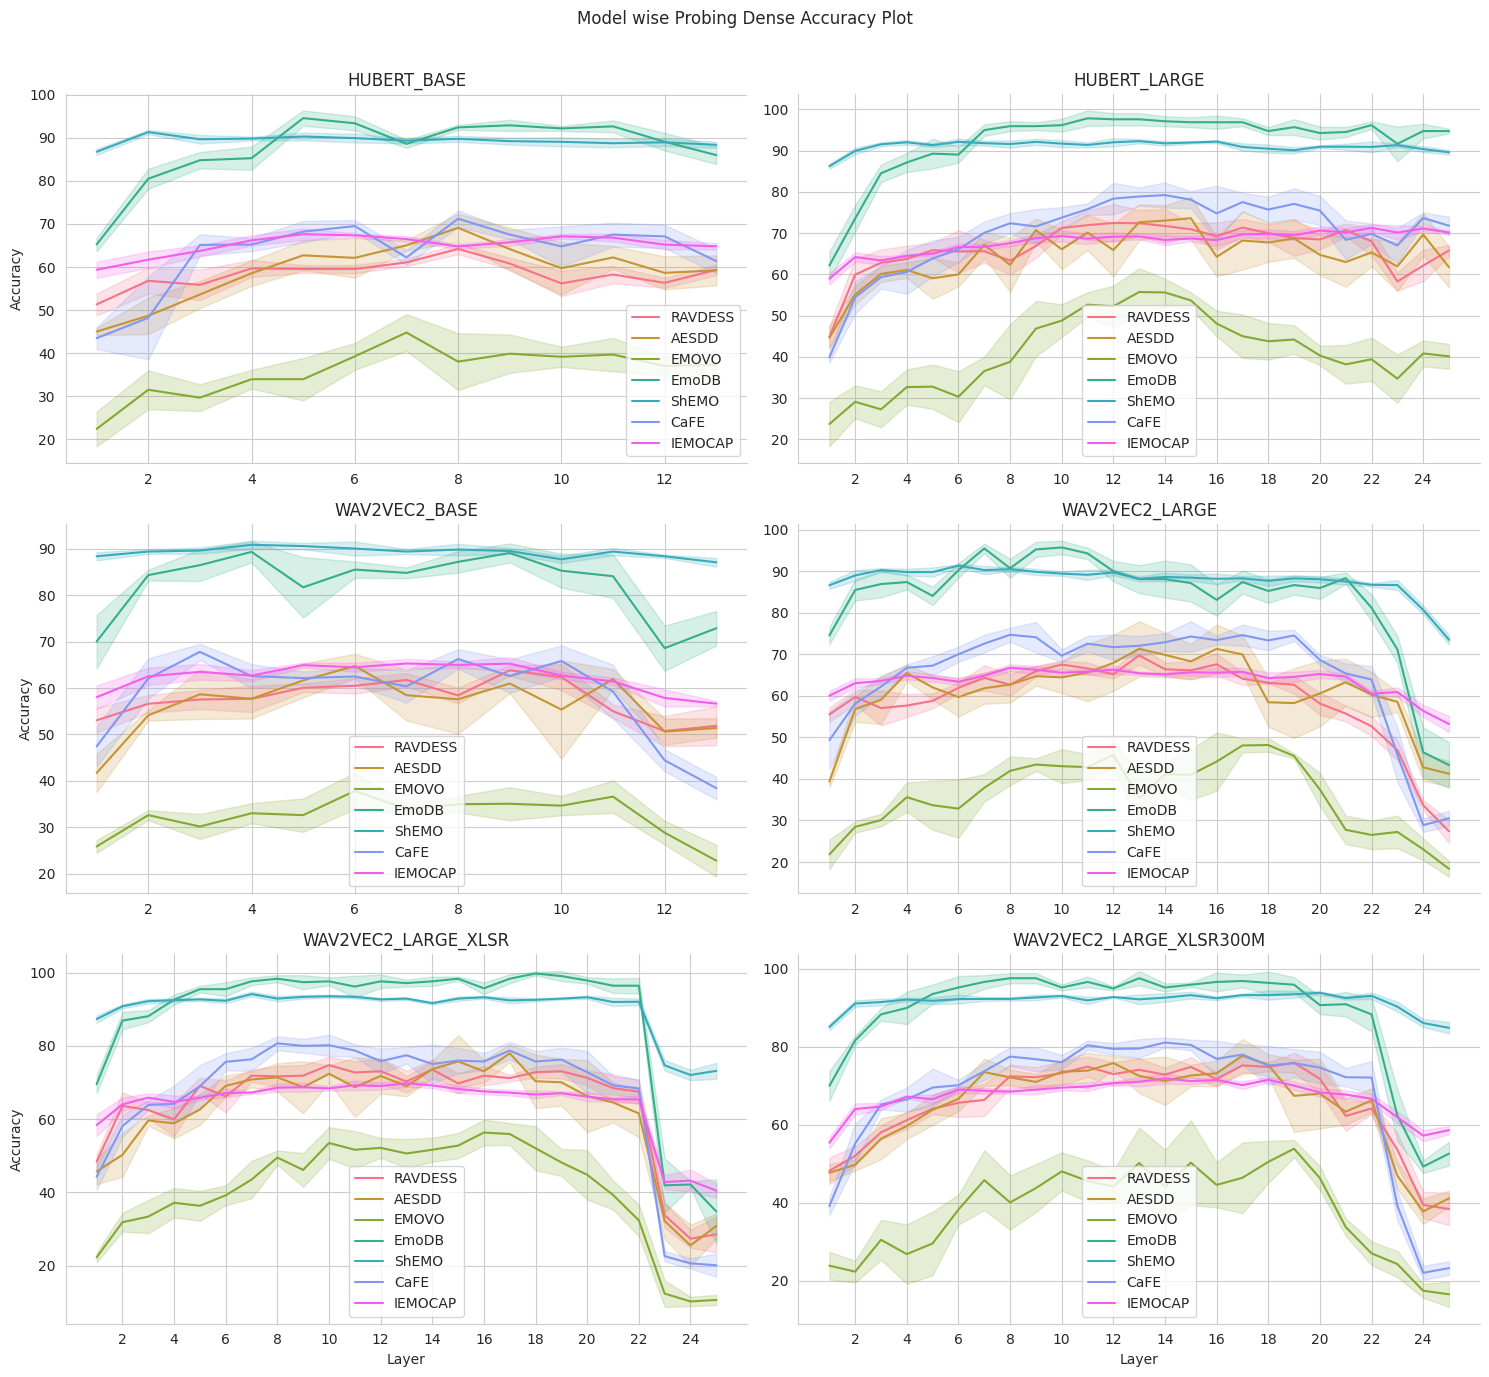

In [55]:
# Set figure
fig, ax = plt.subplots(3, 2,figsize=(15,14))
sns.set_style('whitegrid')

axes = np.array(ax).flatten()
models = sorted(probing_dense_summary.model.unique())
for idx in range(len(models)):
    ax = axes[idx]
    model= models[idx]
    mean_accs, layers, datasets = [], [], []
    df = probing_dense_summary[probing_dense_summary.model==model]
    for row in range(df.shape[0]):
        mean_accs.extend(df.iloc[row].mean_accuracy)
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)+np.array(df.iloc[row].std_accuracy))
        mean_accs.extend(np.array(df.iloc[row].mean_accuracy)-np.array(df.iloc[row].std_accuracy))
        datasets.extend(([df.iloc[row].dataset]*len(df.iloc[row].mean_accuracy)*3))
        layers.extend([*range(1,len(df.iloc[row].mean_accuracy)+1)]*3)
    df = pd.DataFrame.from_dict(dict(dataset=datasets,layer=layers,mean_accuracy=mean_accs))

    # Plot the lines
    sns.lineplot(df ,x='layer',y='mean_accuracy', hue='dataset',dashes=False,palette=sns.color_palette("husl",len(df.dataset.unique())),errorbar=('ci',100),ax=ax)   
    # Adjust border
    sns.despine(top=True,right=True)

    # Set Labels, legends and ticks
    ax.set_title(model)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(facecolor="w")#,loc=4,title='IDR')
    ax.set_xticks([*range(2,len(df.layer.unique())+1,2)],labels=[*range(2,len(df.layer.unique())+1,2)])
    # ax.set_xlim(1,30.6)

# Plot
axes[-1].set_xlabel("Layer")
axes[-2].set_xlabel("Layer")
axes[0].set_ylabel("Accuracy")
axes[2].set_ylabel("Accuracy")
axes[4].set_ylabel("Accuracy")
plt.suptitle('Model wise Probing Dense Accuracy Plot\n\n')
plt.tight_layout()

plt.savefig(os.path.join(output_dir,'model_wise_probing_dense_accuracy_plot.png'),bbox_inches="tight");
# plt.savefig(os.path.join(output_dir,'model_wise_probing_accuracy_plot.svg'),bbox_inches="tight");


# plt.clf();
# plt.close('all');

In [48]:
plt.clf()
plt.close('all')